In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['week'] = df[date_col].dt.week
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['day'] = df[date_col].dt.dayofyear
    return df 

### Looking at Generation Data

In [76]:
actual_gen = pd.read_csv('actual_gen.csv')

In [77]:
actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

actual_gen = actual_gen.drop(['datetime_beginning_ept', 'fuel_percentage_of_total', 'is_renewable'], axis=1)
pivot_df = actual_gen.pivot(index='datetime_beginning_utc', columns='fuel_type', values='mw')


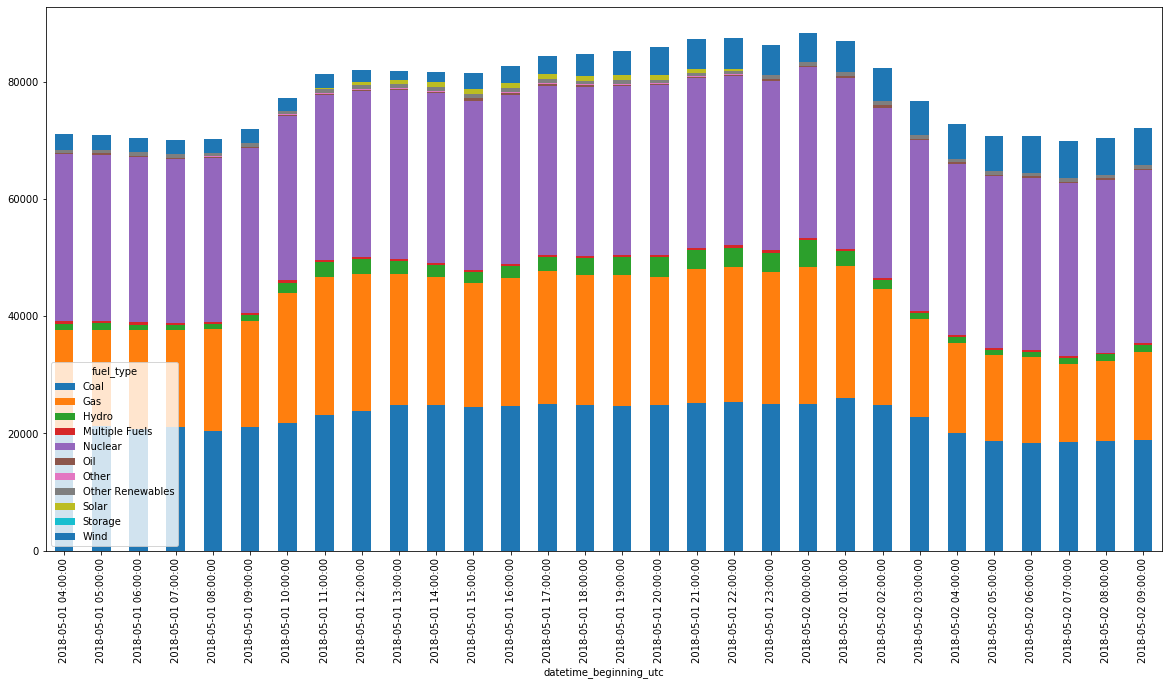

In [90]:
pivot_df_segment = pivot_df.head(30)
pivot_df_segment.plot.bar(stacked=True, figsize=(20,10))

### Get Solar, Wind, Hydro Data

In [88]:
actual_gen = pd.concat(map(pd.read_csv, ['gen_by_fuel_type/2016.csv', 'gen_by_fuel_type/2017.csv','gen_by_fuel_type/2018.csv']))

actual_gen['datetime_beginning_utc'] = pd.to_datetime(actual_gen['datetime_beginning_utc'])

actual_gen = extract_date(actual_gen, 'datetime_beginning_utc')

actual_gen.drop(['datetime_beginning_utc', 'datetime_beginning_ept', 'fuel_percentage_of_total', 'is_renewable'], axis = 1, inplace=True)

In [89]:
hydro_solar_wind = actual_gen.loc[actual_gen['fuel_type'].isin(['Hydro', 'Solar', 'Wind'])]

hydro_solar_wind = hydro_solar_wind.groupby(['year', 'month', 'day', 'hour']).sum().reset_index()

hydro_solar_wind.drop(['week'], axis = 1, inplace=True)

hydro_solar_wind = hydro_solar_wind.pivot_table(index = ['year','month', 'day'], columns="hour", values=hydro_solar_wind.columns)
hydro_solar_wind.columns = hydro_solar_wind.columns.map('{0[0]}|{0[1]}'.format)

hydro_solar_wind.dropna(inplace=True)

### Get weather data

In [90]:
X_train = pd.read_csv("X_train_after_pca.csv")
X_test = pd.read_csv("X_test_after_pca.csv")

In [91]:
X_train.set_index(['year', 'month', 'day'], inplace = True)
X_test.set_index(['year', 'month', 'day'], inplace = True)

In [100]:
index = hydro_solar_wind.index.difference(X_train.index)
y_train = hydro_solar_wind.drop(index)

In [103]:
index = hydro_solar_wind.index.difference(X_test.index)
y_test = hydro_solar_wind.drop(index)

In [114]:
index = X_train.index.difference(y_train.index)
X_train = X_train.drop(index)

index = X_test.index.difference(y_test.index)
X_test = X_test.drop(index)

In [117]:
y_test.to_csv('pred_solar_wind_hydro_v2/y_test.csv')
y_train.to_csv('pred_solar_wind_hydro_v2/y_train.csv')

Standardize Data

In [118]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['day_sin'] = np.sin((df['day']-1)*(2.*np.pi/365))
    df['day_cos'] = np.cos((df['day']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))

    df = df.drop(['month', 'day'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos'])
    return df

In [119]:
X_train = sin_cos_correction(X_train)
X_test = sin_cos_correction(X_test)

In [120]:
from sklearn.preprocessing import StandardScaler

# Standardize features 
scaler = StandardScaler()
scaler.fit(X_train.values) # fit on training set 

scaled_X_train = scaler.transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

# Convert back to df after scaling 
X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)

In [121]:
X_test.to_csv('pred_solar_wind_hydro_v2/X_test.csv')
X_train.to_csv('pred_solar_wind_hydro_v2/X_train.csv')

In [122]:
X_train

0         1         2  \
year month_sin month_cos day_sin   day_cos                                   
2016  0.0       1.000000  0.017213  0.999852  1.369891 -0.171403 -0.950150   
                          0.034422  0.999407  1.355369 -0.112007 -0.053652   
                          0.051620  0.998667  1.619570  0.313614 -0.224731   
                          0.068802  0.997630  1.978571 -1.354081 -0.564457   
                          0.085965  0.996298  1.650712 -1.917616 -0.365560   
...                                                ...       ...       ...   
2017 -0.5      -0.866025 -0.816538 -0.577292 -0.670475 -0.295796 -0.469867   
                         -0.826354 -0.563151 -0.669393 -0.223807 -0.204550   
                         -0.835925 -0.548843 -0.630835 -0.294272 -0.734636   
                         -0.845249 -0.534373 -0.704539 -0.555079 -0.517689   
                         -0.854322 -0.519744 -0.739478  0.365488  0.076396   

                                                   0.1       1.1       2.1  \
year month_sin month_cos day_sin   day_cos                                   
2016  0.0       1.000000  0.017213  0.999852  1.287203 -0.180109 -0.799494   
                          0.034422  0.999407  1.242203  0.041198 -0.669932   
                          0.051620  0.998667  1.587056  0.277229 -0.409974   
                          0.068802  0.997630  2.046157 -1.517361 -0.077857   
                          0.085965  0.996298  1.732972 -1.397330 -0.818098   
...                                                ...       ...       ...   
2017 -0.5      -0.866025 -0.816538 -0.577292 -0.602146 -0.200144 -0.280298   
                         -0.826354 -0.563151 -0.766068 -0.831899 -0.447416   
                         -0.835925 -0.548843 -0.892764 -0.473775 -0.567701   
                         -0.845249 -0.534373 -0.853661 -0.469938 -0.525672   
                         -0.854322 -0.519744 -0.868641  0.375021  0.433354   

                                                   0.2       1.2       2.2  \
year month_sin month_cos day_sin   day_cos                                   
2016  0.0       1.000000  0.017213  0.999852  0.574907  0.045475 -1.535135   
                          0.034422  0.999407 -0.173298 -0.710610 -1.012975   
                          0.051620  0.998667  0.955424 -2.271278  0.197635   
                          0.068802  0.997630  2.948725 -0.408589 -0.069496   
                          0.085965  0.996298  2.462827  1.055231 -0.530522   
...                                                ...       ...       ...   
2017 -0.5      -0.866025 -0.816538 -0.577292  0.817982  0.338548  1.373981   
                         -0.826354 -0.563151  0.458521  0.583548  1.170964   
                         -0.835925 -0.548843  0.105770  0.155534  1.581093   
                         -0.845249 -0.534373 -0.070648 -0.276426  0.302141   
                         -0.854322 -0.519744  0.034729 -0.659089  0.858522   

                                                     3  ...      15.2  \
year month_sin month_cos day_sin   day_cos              ...             
2016  0.0       1.000000  0.017213  0.999852  0.192340  ... -0.154358   
                          0.034422  0.999407 -1.510450  ... -0.200313   
                          0.051620  0.998667 -0.604231  ... -1.005552   
                          0.068802  0.997630  0.523079  ...  0.734909   
                          0.085965  0.996298 -1.268266  ... -0.821282   
...                                                ...  ...       ...   
2017 -0.5      -0.866025 -0.816538 -0.577292 -0.145224  ...  0.169823   
                         -0.826354 -0.563151 -0.387420  ...  0.641802   
                         -0.835925 -0.548843 -0.982611  ...  0.844858   
                         -0.845249 -0.534373  0.099620  ...  0.622468   
                         -0.854322 -0.519744 -0.492086  ... -0.898764   

                                                  16.2    

In [123]:
y_train

mw|0    mw|1    mw|2    mw|3    mw|4    mw|5    mw|6  \
year month day                                                           
2016 1     2    4136.9  4119.7  4038.5  3991.0  3979.5  3909.9  3890.9   
           3    4449.1  4916.0  4788.6  4500.9  4434.4  4569.3  4263.8   
           4    2774.4  2469.9  2209.2  2204.0  2220.2  2232.9  1987.0   
           5    3549.3  2930.5  2368.9  1824.4  1939.1  1881.4  2044.4   
           6    2684.5  2794.2  2773.5  2990.9  2749.0  2737.0  2855.6   
...                ...     ...     ...     ...     ...     ...     ...   
2017 8     239  1870.1  2083.1  2374.8  2382.1  2584.2  2601.0  2293.2   
           240  3737.0  2367.9  1462.7  1643.6  1778.8  1486.8  1684.9   
           241  3796.1  2230.2  1426.6  1388.8  1326.0  1223.5  1209.0   
           242  2890.3  1362.7   890.3   750.7   567.8   506.9   567.3   
           243  2733.1   943.4   492.7   673.7   729.5   708.1   902.2   

                  mw|7    mw|8    mw|9  ...   mw|14   mw|15   mw|16   mw|17  \
year month day                          ...                                   
2016 1     2    3781.5  3437.4  3023.9  ...  1933.9  2057.6  2316.8  2375.7   
           3    4068.2  4008.0  3713.3  ...  2349.6  2374.6  2308.2  2395.8   
           4    2059.3  2467.7  2741.7  ...  2825.9  2539.3  2653.7  2570.8   
           5    2103.7  1828.0  1642.0  ...  2012.1  1744.8  1576.5  1374.6   
           6    2609.6  2679.5  2533.3  ...  2453.8  1651.9  1261.9  1104.9   
...                ...     ...     ...  ...     ...     ...     ...     ...   
2017 8     239  2380.6  2359.2  2124.8  ...  1476.9  1494.9  1758.0  1858.7   
           240  1497.8  1314.5  1328.7  ...  1666.0  1826.8  2559.8  5030.7   
           241  1207.7   982.6   887.3  ...   953.7  1455.7  1468.6  2314.7   
           242   408.3   369.7   356.4  ...  1153.0  1762.9  1767.1  2076.7   
           243  1260.9  1588.0  1303.1  ...  2121.7  2179.3  4327.9  5644.1   

                 mw|18   mw|19   mw|20   mw|21   mw|22   mw|23  
year month day                                                  
2016 1     2    2719.4  2794.5  2872.0  2810.5  3915.3  4234.3  
           3    2539.9  2381.3  2526.8  2532.2  3515.0  3227.7  
           4    2819.4  2497.4  2742.1  2566.3  2983.5  3738.1  
           5    1577.9  1309.3  1370.1  1248.2  2009.6  2377.5  
           6    1091.3  1060.0   987.6  1147.8  1965.4  2088.1  
...                ...     ...     ...     ...     ...     ...  
2017 8     239  1673.0  3803.5  5310.5  5574.1  4517.0  3159.8  
           240  6131.3  6161.0  5914.6  5862.6  4917.2  4614.7  
           241  3076.1  3576.0  3640.9  3967.6  2540.8  1898.2  
           242  4112.2  5576.6  5879.6  5819.7  4474.0  3649.4  
           243  6785.4  7277.4  7816.1  7444.4  5982.8  4970.5  

[597 rows x 24 columns]

### Nuclear Generation 

In [230]:


nuclear = actual_gen.loc[actual_gen['fuel_type'] == 'Nuclear']
nuclear = nuclear.drop(['fuel_type', 'datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)

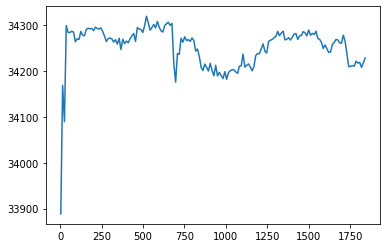

In [159]:
nuclear_segment = nuclear.head(168)
plt.plot(nuclear_segment['mw'])

##### Weekly Average for Nuclear

In [160]:
nuclear_weekly = nuclear.groupby( ['year', 'week'] ).mean().reset_index()

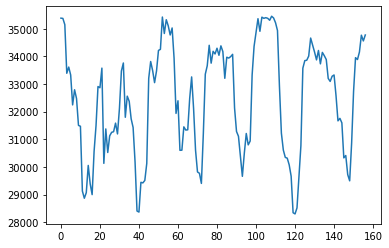

In [161]:
plt.plot(nuclear_weekly['mw'])

In [162]:
nuclear_weekly = nuclear_weekly[['year', 'week', 'mw']]
nuclear_weekly.to_csv('nuclear_weekly_average.csv')

### Hydro Generation

In [253]:
hydro = actual_gen.loc[actual_gen['fuel_type'] == 'Hydro']

In [254]:
hydro

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable,hour,week,month,year,day,doy
2,2016-12-31 05:00:00,12/31/2016 12:00:00 AM,Hydro,704.8,0.01,True,5,52,12,2016,31,366
13,2016-12-31 04:00:00,12/30/2016 11:00:00 PM,Hydro,786.9,0.01,True,4,52,12,2016,31,366
24,2016-12-31 03:00:00,12/30/2016 10:00:00 PM,Hydro,768.9,0.01,True,3,52,12,2016,31,366
35,2016-12-31 02:00:00,12/30/2016 9:00:00 PM,Hydro,1393.9,0.01,True,2,52,12,2016,31,366
46,2016-12-31 01:00:00,12/30/2016 8:00:00 PM,Hydro,4422.1,0.04,True,1,52,12,2016,31,366
...,...,...,...,...,...,...,...,...,...,...,...,...
96052,2018-01-01 09:00:00,1/1/2018 4:00:00 AM,Hydro,431.2,0.00,True,9,1,1,2018,1,1
96063,2018-01-01 08:00:00,1/1/2018 3:00:00 AM,Hydro,432.0,0.00,True,8,1,1,2018,1,1
96074,2018-01-01 07:00:00,1/1/2018 2:00:00 AM,Hydro,349.6,0.00,True,7,1,1,2018,1,1
96085,2018-01-01 06:00:00,1/1/2018 1:00:00 AM,Hydro,1044.2,0.01,True,6,1,1,2018,1,1


In [255]:
hydro = hydro.drop(['fuel_type', 'datetime_beginning_ept', 'fuel_type', 'fuel_percentage_of_total', 'is_renewable'], axis = 1)

In [256]:
# Pivot so hydro is by hour
hydro = hydro.pivot_table(index = ['year','month', 'doy'], columns="hour", values=['mw'])
hydro.columns = hydro.columns.map('{0[0]}|{0[1]}'.format)

In [257]:
hydro

mw|0    mw|1    mw|2    mw|3    mw|4    mw|5    mw|6  \
year month doy                                                           
2016 1     1       NaN     NaN     NaN     NaN     NaN   682.9   641.2   
           2    1318.5  1028.0   835.8   670.0   662.1   602.6   598.6   
           3     944.9   959.6   750.4   576.7   595.1   679.5   612.7   
           4    1304.1   854.0   638.1   584.5   649.4   603.5   479.3   
           5    1959.1  1451.4   959.7   594.7   583.4   436.5   534.8   
...                ...     ...     ...     ...     ...     ...     ...   
2018 12    361  4178.0  3774.6  2607.0  2035.7  2042.6  2060.1  2010.1   
           362  2558.3  2555.3  2181.4  2040.3  2008.6  1898.2  1888.2   
           363  2752.7  2161.1  2151.4  2150.0  2061.1  2162.4  2136.4   
           364  3757.5  2194.1  2225.0  2375.6  2308.2  2096.2  2085.9   
           365  3743.3  3101.7  2764.0  2177.1  2121.3  2064.8     NaN   

                  mw|7    mw|8    mw|9  ...   mw|14   mw|15   mw|16   mw|17  \
year month doy                          ...                                   
2016 1     1     622.5   520.1   572.8  ...   758.3   755.0   716.1   684.5   
           2     601.7   642.8   585.1  ...   648.3   639.1   689.3   637.3   
           3     617.1   641.8   654.3  ...   694.8   657.1   700.6   670.2   
           4     507.4   526.7   488.2  ...  1144.5   656.0   586.2   663.8   
           5     403.9   455.2   292.3  ...   710.7   628.0   605.7   410.1   
...                ...     ...     ...  ...     ...     ...     ...     ...   
2018 12    361  2010.1  2010.1  2010.1  ...  2739.1  2115.4  2096.4  2079.3   
           362  1904.5  1892.7  1879.6  ...  2567.2  2139.7  2041.0  2005.2   
           363  2038.4  2038.1  2078.6  ...  2235.7  2219.9  2216.0  2237.9   
           364  2104.1  2130.2  2132.1  ...  2120.7  2288.8  2283.8  2291.8   
           365     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   

                 mw|18   mw|19   mw|20   mw|21   mw|22   mw|23  
year month doy                                                  
2016 1     1     640.5   640.1   625.7   662.5  1513.6  1601.6  
           2     615.3   650.6   646.4   652.7  1525.7  1245.7  
           3     652.6   616.6   616.0   660.2  1765.2  1689.5  
           4     545.6   547.2   638.4   598.3  1141.9  2021.6  
           5     542.9   412.7   667.0   554.9  1477.2  1467.5  
...                ...     ...     ...     ...     ...     ...  
2018 12    361  1990.2  1990.6  1983.8  2345.1  3891.5  3018.4  
           362  2006.2  2071.5  2059.2  2188.5  4433.1  3946.6  
           363  2119.8  2112.6  2270.6  2119.0  3948.5  4312.8  
           364  2062.8  2071.5  2071.5  2324.8  4252.6  4313.7  
           365     NaN     NaN     NaN     NaN     NaN     NaN  

[1094 rows x 24 columns]

##### Get Weather Data

In [212]:
weather = pd.concat(map(pd.read_csv, ['processed_data/raw_weather_train.csv', 'processed_data/raw_weather_test.csv']))

In [213]:
# Add a few more date columns 
weather['datetime'] = pd.to_datetime(weather['year'] * 1000 + weather['day'], format='%Y%j')

weather['week'] = weather['datetime'].dt.week
weather['doy'] = weather['datetime'].dt.dayofyear
weather['day'] = weather['datetime'].dt.day

In [222]:
weather = weather.drop(['datetime'], axis = 1)

In [258]:
features = weather.copy(deep=True)
target = hydro.copy(deep=True)

In [259]:
features = features.set_index(['year', 'month', 'doy'])

target = target.reset_index()
target = target.set_index(['year', 'month', 'doy'])

target = target.dropna()

In [260]:
# Drop extra rows in target 
indx = target.index.difference(features.index)
target = target.drop(indx)

# Drop extra rows in features 
indx = features.index.difference(target.index)
features = features.drop(indx)

### Circular Encoding

In [272]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['doy_sin'] = np.sin((df['doy']-1)*(2.*np.pi/365))
    df['doy_cos'] = np.cos((df['doy']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))
    df['week_sin'] = np.sin((df['month']-1)*(2.*np.pi/52))
    df['week_cos'] = np.cos((df['month']-1)*(2.*np.pi/52))
    
    df = df.drop(['month', 'doy'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos'])
    return df

In [275]:
features = sin_cos_correction(features)

features = features.drop(['week', 'day'], axis =1)

In [276]:
target = sin_cos_correction(target)

### Train / Test Split

In [278]:
def split(df):
    # 80-20 split 
    df = df.copy()
    
    train_pct_index = int(0.8 * len(df))
    X_train, X_test = df[:train_pct_index], df[train_pct_index:]

    return X_train, X_test

In [279]:
X_train, X_test = split(features)
Y_train, Y_test = split(target)

In [ ]:
Y_test1.to_csv("predict_simple_dispatch/test_index.csv")

### Standardize and Save 

In [281]:
from sklearn.preprocessing import StandardScaler

In [282]:
# Standardize features 
scaler = StandardScaler()
scaler.fit(X_train.values) # fit on training set 

scaled_X_train = scaler.transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

# Convert back to df after scaling 
X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)

In [283]:
X_train.to_csv("hydro/X_Train.csv")
X_test.to_csv("hydro/X_Test.csv")

In [284]:
Y_train.to_csv("hydro/Y_train.csv")
Y_test.to_csv("hydro/Y_test.csv")